In [2]:
# Imports

# pandas , numpy 데이터 분석
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

# matplotlib, seaborn 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning 머신러닝
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
# get titanic & test csv files as a DataFrame 파일 읽어들이기
titanic_df = pd.read_csv("C:/Users/82102/titanic/input/train.csv")
test_df    = pd.read_csv("C:/Users/82102/titanic/input/test.csv")

# preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 결측치 확인하기

titanic_df.info()
print("----------------------------")
test_df.info()

# titanic_df - Age, Cabin, Embarked
# test_df - Age, Cabin, Fare

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-

In [5]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
# 데이터 분석에 필요없는 칼럼 제거
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1) #axis = 1은 칼럼을 말함 
test_df    = test_df.drop(['Name','Ticket'], axis=1)

In [6]:
# Embarked

print(titanic_df['Embarked'].describe()['top']) #데이터에서 최빈값 출력

S


C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


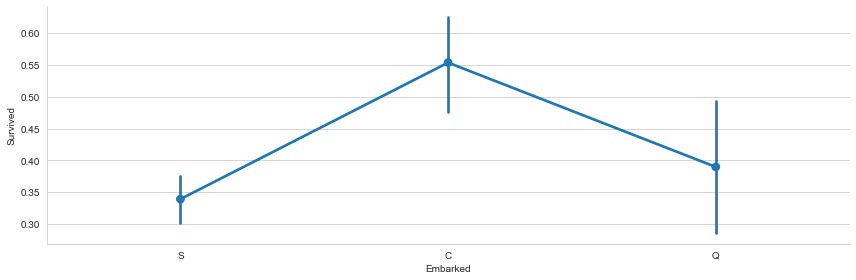

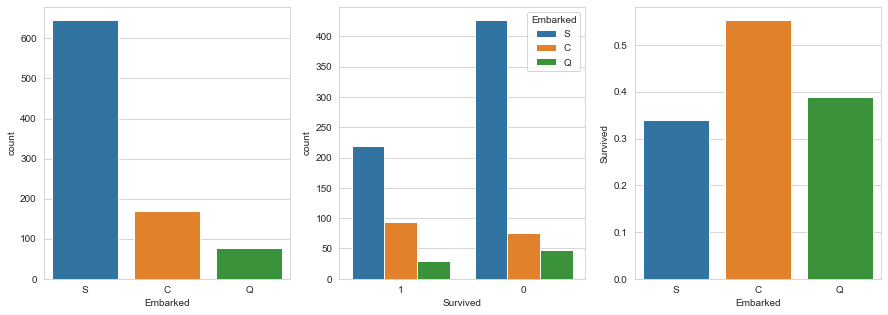

In [7]:
# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
# 최빈값을 바탕으로 결측치를 'S'로 채움
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")


#factorplot은 꺾은선 그래프 - Embarked 생존자 그래프
sns.factorplot('Embarked','Survived', data=titanic_df,height=4,aspect=3) 


fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5)) #1행 3열로 그래프 그림

sns.countplot(x='Embarked', data=titanic_df, ax=axis1)  # Enbarked에 따른 명수 그래프
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2) # Enbarked에 따른 생존자 명수 그래프(survived=1)

# group by embarked, and get the mean for survived passengers for each value in Embarked 데이터 그룹화 후 생존자 평균 계산
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)



In [8]:
# 생존률 S<Q<C 순


# 여기서 2가지 경우로 처리할 수 있음
# 생존률이 상대적으로 낮은 S를 제거하고 C, Q만 남겨놓거나,
# 아예 Embarked 칼럼을 버리거나 (논리적으로 예측에 유용해 보이지 않는다고함)

# 여기서 전자의 경우를 선택함

'''
결과적으로 생존유무를 예측하는 모델인데, 생존률이 낮다고 해서 버리는 이유...?

예측의 정확도를 높이기 위해 데이터 선별하는 기준 - Feature Selection

feature가 너무 많으면 overfitting의 위험이 있고, 모델이 이상적인 방향으로 학습을 하지 않을 위험이 있음

Feature selection methods can be used to identify and remove irrelevant and redundant features from data, 
hopefully, without affecting the accuracy of a predictive model.
예측 모델의 정확도에 영향을 미치지 않고 데이터에서 부적절하고 중복된 형상을 식별하고 제거할 수 있음

1. Wrapper Methods : 이를 조합을 바꿔가면서, 계속 반복
2. Filter Methods : 상관계수를 이용한 통계적 방법으로 실행
3. Embedded Methods : 모델 자체에 Feature selection 기능이 추가되어 있는 경우

Multicollinearity 다중공산성

'''




# One-hot encoding : 문자로 된 데이터를 0, 1로 바꾸어 주는 방법 (pd.get_dummies 사용) 범주형 -> 연속형
# inplace 옵션에 True를 주면 또 다른 객체를 반환하지 않고 기존 객체를 수정
embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

# 데이터에 연결
titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

# 기존의 Enbarked 칼럼은 버림
titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q
0,0,3,male,22.0,1,0,7.2500,NaN,0,0
1,1,1,female,38.0,1,0,71.2833,C85,1,0
2,1,3,female,26.0,0,0,7.9250,NaN,0,0
3,1,1,female,35.0,1,0,53.1000,C123,0,0
4,0,3,male,35.0,0,0,8.0500,NaN,0,0


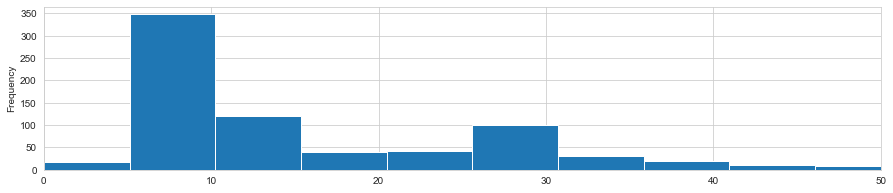

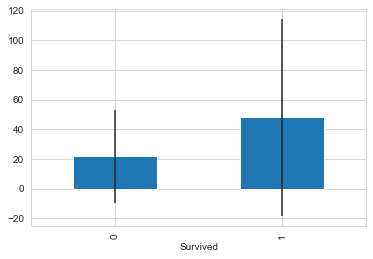

In [23]:
# Fare 


# test_df 데이터만 결측치 존재 -> 중앙값으로 채워줌
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# 데이터 타입을 실수에서 정수로 변환 
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot
titanic_df['Fare'].plot(kind='hist', figsize=(15,3),bins=100, xlim=(0,50))

avgerage_fare.index.names = std_fare.index.names = ["Survived"] 
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False) # 0은 사망자, 1은 생존자


C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


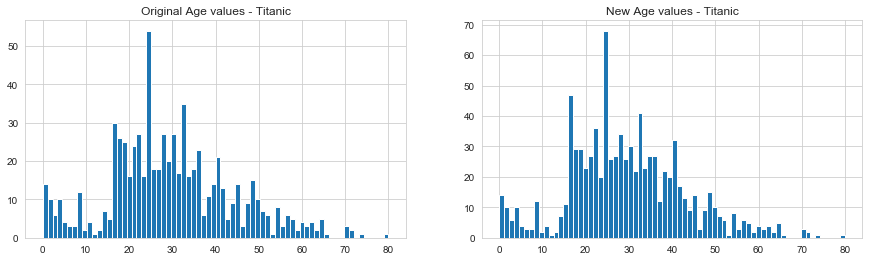

In [10]:
# Age 


fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')


# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()


# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()


# (평균 - 표준편차)와 (평균 + 표준편차) 값 사이의 랜덤변수 설정 --> 결측치 보정하기 위함
rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)


# plot original Age values
# 결측치는 버리고 int로 형변환한 그래프
titanic_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
# test_df['Age'].dropna().astype(int).hist(bins=70, ax=axis1)


# Age의 결측치를 위에서 설정한 랜덤값으로 채워줌
# np.isnan : 결측치일경우 True, 아닐경우 False 반환
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2


# float 에서 int로 형변환
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)
 
    
# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)
# test_df['Age'].hist(bins=70, ax=axis4)

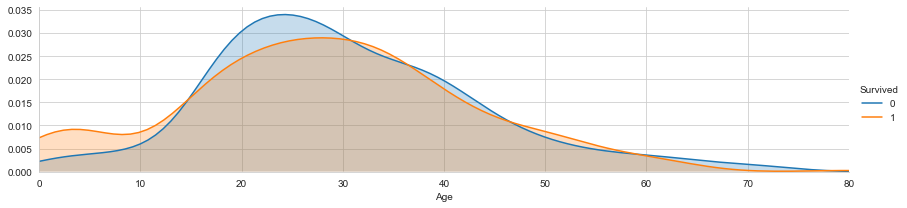

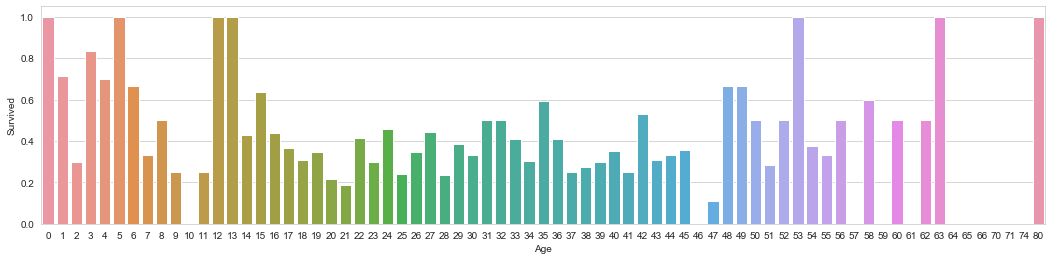

In [11]:
# .... continue with plot Age column

# 나이에 따른 생존자와 사망자 그래프
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4) # 그리드 초기화
facet.map(sns.kdeplot,'Age',shade= True) # shade: 곡선 아래의 공간을 음영 처리할지 결정
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

# 나이에 따른 생존 확률 그래프
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [12]:
# Cabin

# 결측치가 많아 예측에 별다른 역할을 하지 않을 것으로 보임 -> 칼럼 버림
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[Text(0, 0, 'With Family'), Text(0, 0, 'Alone')]

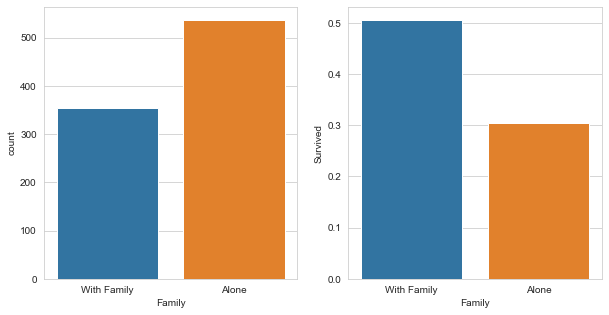

In [13]:
# Family (Parch + SibSp)

# Parch와 SibSp 두개를 합쳐서 가족멤버가 있을때의 생존 여부를 따짐

titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]

# loc을 이용한 데이터 조건 활용
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1 # 가족이 1명 이상있는 경우 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0 # 그 외의 경우 0

test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0

# drop Parch & SibSp
titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))


# 가족 유무 그래프
sns.countplot(x='Family', data=titanic_df, order=[1,0], ax=axis1)

# 가족 유무에 따른 생존 그래프
family_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

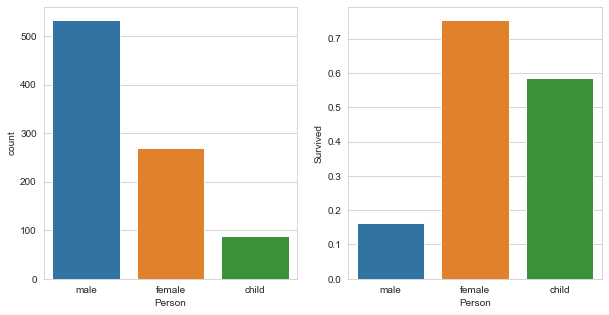

In [14]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# Age에서 보았을때 16세 미만의 아이들이 생존에서 높은 확률을 보임
# 따라서 승객을 남성, 여성, 아이들로 분류

def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

# Apply 함수 이용
# Person = child + female + male
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# Person에 정보 다 들어갔으므로 Sex는 버림
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# One-hot encoding : 문자로 된 데이터를 0, 1로 바꾸어 주는 방법 (pd.get_dummies 사용) 
# 남성은 버림 (생존 승객 중 가장 낮은 생존률을 보였기 때문)
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

# 붙히기
titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)


# 그래프
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

# Child, Female 이 칼럼에 들어갔으므로 Person은 버림
titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


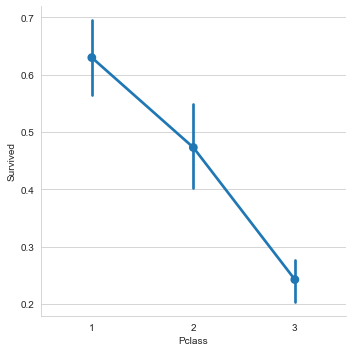

In [15]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

# One-hot encoding : 문자로 된 데이터를 0, 1로 바꾸어 주는 방법 (pd.get_dummies 사용) 
# 3rd class 는 버림 (생존 승객 중 가장 낮은 생존률을 보였기 때문)
pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

titanic_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [16]:
# define training and testing sets

X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]
X_test  = test_df.drop("PassengerId",axis=1).copy()

In [17]:
# Logistic Regression 로지스틱 회귀

logreg = LogisticRegression()

logreg.fit(X_train, Y_train) # 모델 학습

Y_pred = logreg.predict(X_test) # 값 예측

logreg.score(X_train, Y_train) # 결정계수

C:\Users\82102\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8080808080808081

In [18]:
# Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

0.6801346801346801

In [30]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.9685746352413019

In [38]:
# Knn

knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.8159371492704826

In [21]:
# Gaussian Naive Bayes (feature가 서로 독립일때만 사용가능)

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

gaussian.score(X_train, Y_train)

0.7586980920314254

In [22]:
# 상관계수
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
coeff_df

,Features,Coefficient Estimate
0,Age,-0.019935
1,Fare,0.001031
2,C,0.604273
3,Q,0.267835
4,Family,-0.252167
5,Child,1.978323
6,Female,2.789948
7,Class_1,2.033493
8,Class_2,1.164989
